In [86]:
import glob

frac_imgs_path = glob.glob('./Scaphoid/Images/Fracture/*')
norm_imgs_path = glob.glob('./Scaphoid/Images/Normal/*')
frac_cord_path = glob.glob('./Scaphoid/Annotations/Fracture_Coordinate/*')
slice_path = glob.glob('./Scaphoid/Annotations/Scaphoid_Slice/*') # json 檔

print(len(frac_imgs_path), len(norm_imgs_path), len(frac_cord_path), len(slice_path))


120 120 120 240


In [87]:
import pandas as pd
import json
import numpy as np
import os
df = pd.DataFrame(columns = ['img_id' , 'frac', 'x1', 'y1', 'x2', 'y2'])
for i in slice_path:
    basename = os.path.basename(i)
    img_id = os.path.splitext(basename)[0]
    # print(img_id)
    with open('./Scaphoid/Annotations/Scaphoid_Slice/' + img_id + '.json') as f:
            data_bbox = json.load(f)[0]['bbox']
    if os.path.exists('./Scaphoid/Annotations/Fracture_Coordinate/' + img_id + '.csv'): # 在 Fracture 的資料夾中
        df = df.append({'img_id':img_id ,
                        'frac':float(1), # '1' stands for fracture scaphoid
                        'x1':int(data_bbox[0]), 
                        'y1':int(data_bbox[2]), 
                        'x2':int(data_bbox[1]), 
                        'y2':int(data_bbox[3])} , ignore_index=True)

    else:
        df = df.append({'img_id':img_id ,
                        'frac':float(0),  # '0' stands for fracture scaphoid
                        'x1':int(data_bbox[0]), 
                        'y1':int(data_bbox[2]), 
                        'x2':int(data_bbox[1]), 
                        'y2':int(data_bbox[3])} , ignore_index=True)


print(len(df))
df.head()

240


,img_id,frac,x1,y1,x2,y2
0,00075616-AP0,1.0,751,873,794,945
1,00169382 L 51F AP0,0.0,751,873,794,945
2,00230304 R 50F AP0,0.0,751,873,794,945
3,00293717 L 77M AP0,0.0,751,873,794,945
4,00454212-LOB0,1.0,585,776,996,1189


In [185]:
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize, Flip,
                            Compose, GaussNoise)
import torchvision.transforms as transforms


# Albumentations
def get_train_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])
def get_valid_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

In [186]:
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
class Clip_classification_HandDataset(Dataset):
    def __init__(self, data_frame, transforms) -> None:
        super().__init__()
        self.df = data_frame
        self.images = data_frame['img_id']
        # print(len(self.images))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # print(idx, self.images[idx])
        # print(self.images[idx])
        image_filename = str(self.images[idx]) + '.bmp'
        # print(image_filename)
        if os.path.exists('./Scaphoid/Images/Fracture/' + image_filename): # 在 Fracture 的資料夾中
            image_arr = cv2.imread('./Scaphoid/Images/Fracture/' + image_filename, cv2.IMREAD_COLOR)
        elif os.path.exists('./Scaphoid/Images/Normal/' + image_filename): # 在 Normal 的資料夾中
            image_arr = cv2.imread('./Scaphoid/Images/Normal/' + image_filename, cv2.IMREAD_COLOR)
        else:
            print("Error Loading img")
        
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32) 
        image_arr /= 255.0
        
        image_id = self.images[idx]
        point = self.df[self.df['img_id'] == image_id]
        clip_bbox = point[['x1', 'x2', 'y1', 'y2']].values   
        image_arr = image_arr[clip_bbox[:, 1][0]:clip_bbox[:, 3][0], clip_bbox[:, 0][0]:clip_bbox[:, 2][0]]
        image_arr = cv2.resize(image_arr, (500, 500), interpolation=cv2.INTER_LINEAR)
        image_arr = image_arr.transpose((2,0,1))

        if point[['frac']].values == 1:
            label = 1
        if point[['frac']].values == 0:
            label = 0
            
        return image_arr, label, image_id


In [187]:
print(len(df))
train_data = Clip_classification_HandDataset(df[:80], get_train_transform())
val = df[200:]
val.reset_index(inplace=True, drop=True)
val_data = Clip_classification_HandDataset(val, get_valid_transform())


# batching
def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)



240


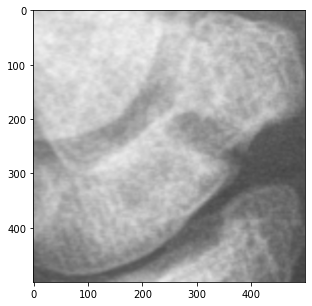

In [192]:
import matplotlib.pyplot as plt

def image_convert(image):
    # image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    # bb = out[1]['boxes'].numpy()
    # for i in bb:
    #     cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=1)
    plt.figure(figsize=(5,5))
    plt.imshow(image)

plot_img(val_data, 2)
# val_data[3]


In [197]:
import torchvision
import time
from tqdm import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)
model = torch.nn.Sequential(
            torchvision.models.resnet50(pretrained=True), 
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 2)
        ).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay=0.0005)
loss_func = torch.nn.CrossEntropyLoss()
num_epochs = 1
train_loss_min = 0.9
total_train_loss = []
number_of_batch = len(train_data) / 4
number_of_data = len(train_data)
for epoch in range(num_epochs):
    # print(f'Epoch :{epoch + 1}')
    correct_predict = 0
    total_batch_loss = 0

    model.train()
    for step, (images, targets, image_ids) in enumerate(tqdm(train_data_loader)):
        images = list(image for image in images)
        images = torch.tensor(images).to(device)
        targets = torch.tensor(targets).to(device)
        output = model(images)
        # print(output)
        
        loss = loss_func(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predict = torch.max(torch.nn.functional.softmax(output, dim = 1), 1)
        correct_predict += (predict.data.cpu() == targets).sum()
        total_batch_loss += loss.data.cpu().numpy()


print("\n Epoch of Training: %.4f" % ((epoch / num_epochs) * 100.), "%", " (loss = {}, accuracy = {}, epoch: {})\n".format(total_batch_loss / number_of_batch, correct_predict / number_of_data, epoch), end=" ")
print("====================================================")

torch.save(model.state_dict(), 'classifier_stage2.pth')


cpu


100%|██████████| 20/20 [04:41<00:00, 14.05s/it]



 Epoch of Training: 0.0000 %  (loss = 0.6909479647874832, accuracy = 0.612500011920929, epoch: 0)
